## Spectral grid fitting for the SALT spectra

We could do this with BT-Settl

The spectra are available here, on a one-by-one basis:

http://svo2.cab.inta-csic.es/theory/newov2/index.php?models=bt-settl


The spectra then need to be rotationally broadened. The broadening can be done with the eniric python package:

https://eniric.readthedocs.io/en/latest/

and the sampling to the instrument resolution of SALT's spectrograph can be done with a native astropy tool via "convolve":

https://docs.astropy.org/en/stable/convolution/


CARMENES spectra:

http://carmenes.cab.inta-csic.es/gto/jsp/reinersetal2018.jsp

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.constants import R_sun

# Get spectra

In [3]:
dirr = "/home/ekaterina/Documents/001_science/MalachiteMountains/data"
sps = []
sp = pd.read_csv(f"{dirr}/salt/R202002090014.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
sps.append(sp)
sps.append(pd.read_csv(f"{dirr}/salt/R202002080017.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"]))
sps.append(pd.read_csv(f"{dirr}/salt/R202002080014.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"]))
settl7 = pd.read_csv(f"{dirr}/btsettl/2700K.tsv", delimiter="\s+", skiprows=10, names=["lambd","flux"])
settl8 = pd.read_csv(f"{dirr}/btsettl/2800K.tsv", delimiter="\s+", skiprows=10, names=["lambd","flux"])
settl0 = pd.read_csv(f"{dirr}/btsettl/3000K.tsv", delimiter="\s+", skiprows=10, names=["lambd","flux"])
settl6 = pd.read_csv(f"{dirr}/btsettl/2600K.tsv", delimiter="\s+", skiprows=10, names=["lambd","flux"])

In [4]:
hdu = fits.open(f"{dirr}/carmenes/carmenes_cnleo_vis.fits")

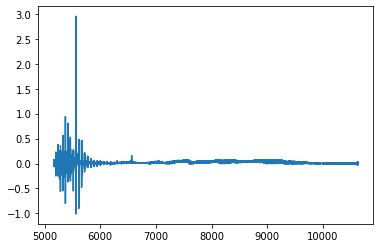

In [5]:
lambd = hdu[4].data.flatten().byteswap().newbyteorder()
flux = hdu[1].data.flatten().byteswap().newbyteorder()
carmenes = pd.DataFrame({"lambd":lambd, "flux":flux}).sort_values(by="lambd", ascending=True)
plt.plot(lambd,flux)

(0.0, 5.0)

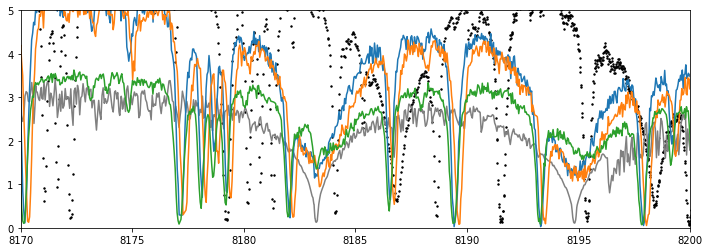

In [6]:
%matplotlib inline



plt.figure(figsize=(12,4))

# CARMENES CN Leo
plt.scatter(lambd,flux*1e2, c="k", s=2)

plt.plot(settl7.lambd, settl7.flux/np.mean(settl7.flux), c="grey")
#plt.plot(settl8.lambd, settl8.flux/np.mean(settl8.flux), c="k")
#plt.plot(settl6.lambd, settl6.flux/np.mean(settl6.flux), c="k")
for sp in sps:
    plt.plot(sp.lambd, sp.flux/np.mean(sp.flux),)

plt.xlim(4000,8880)
#plt.xlim(6570,6580)
#plt.xlim(8100,8320) # Natrium

# plt.xlim(4680,4690) # HeII nothing to be seen
#plt.xlim(7940, 7950) # RbI as 7948
plt.xlim(5880,5900) # 5885 5887 Na I D doublet is in emission
#plt.xlim(6500,6600) # 6565 H alpha is in emission, different intensities

# sodium doublet, shift seen in the tellurics of the three spectra
# Jenkins+2009 https://iopscience.iop.org/article/10.1088/0004-637X/704/2/975/pdf
plt.xlim(8170,8200) 

#plt.xlim(7640, 8050) #Fuhrmeister 2008 7699A KI line

plt.ylim(0,5)

In [7]:
rad = 0.142 * R_sun

rad.to("cm")

<Quantity 9.87894e+09 cm>

In [8]:
wavmin, wavmax = 8160, 8210
sp = sps[-1]
sp.flux = sp.flux/sp.flux.mean()
settl = settl7
#settl.flux = settl6.flux/settl6.flux.mean()
settl.lambd.max()

9992270.0

Hm. Why is effective radius != Sarah's radius or Mamajek"s radius (a little smaller than Sarah's)?

In [9]:
wav = settl.loc[(settl.lambd>wavmin) & (settl.lambd<wavmax),"lambd"].values
wav.shape

(1170,)

# Rotational broadening

[see eniric docs](https://eniric.readthedocs.io/en/latest/broadening.html#rotational-broadening)

In [10]:
from eniric import broaden

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/eniric/__init__.py:23: UserWarning: Using the default config.yaml file located at /home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/eniric/config.yaml. This is likely NOT what you want and you will not be able to change any of the config values. Please use config.copy_file(<path>) to copy a version of the default config for your own project.
  UserWarning,


In [11]:
vsinis = [10,30, 60, 170]#np.arange(10,120,20)

In [12]:
specs = []

for vsini in vsinis:
    specs.append(broaden.rotational_convolution(wav, settl.lambd, settl.flux, vsini))

In [13]:
from astropy.convolution import Gaussian1DKernel, convolve


(1170,)
(1170,)
(1170,)
(1170,)


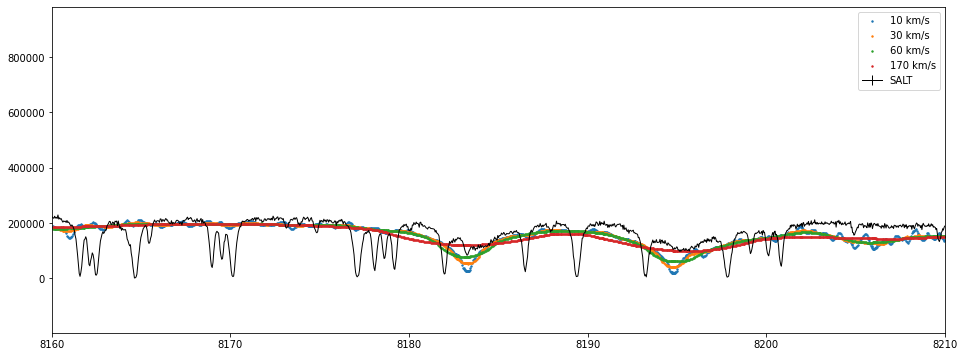

In [15]:
plt.figure(figsize=(16,6))

# Create kernel
g = Gaussian1DKernel(stddev=.004)
g2 = Gaussian1DKernel(stddev=.04)
#specs.append(settl2.flux)
sp=sps[2]
plt.errorbar(sp.lambd, convolve(sp.flux*6.2e4, g2)+0.2, 
             yerr=sp.flux_err, c="k", linewidth=1, label="SALT")
#plt.plot(lamb, settl2.flux, c="k", linewidth=.5)
for vsini, broad_spectrum in zip(vsinis, specs):
    # Convolve data
    z = convolve(broad_spectrum, g)
    z = broad_spectrum
    print(z.shape)
    plt.scatter(wav, z, label=f"{vsini} km/s", s=2)

    
plt.xlim(wavmin,wavmax)
#plt.xlim(wavmin,7960)
#plt.xlim(8193,8200)
#plt.xlim(4180,4200)
#plt.xlim(5888,5899)
plt.axvline(7699, c="r")
#plt.ylim(0,4)
plt.legend();

- Fit the entire spectrum?
- Fit certain lines and continuum?
- Which lines? 
     - KI (potassium) at 7699A and 7666A, 
     - Na (sodium) at 8182–8194A has multiple blended telluric lines
- What free parameters? 
     - offset in continuum
     - normalization
     - rotation


In [71]:
from specutils import Spectrum1D
settl2 = settl[(settl.lambd>wavmin) & (settl.lambd<wavmax)]
lamb = wav* u.AA #settl2.lambd.values 
flux = specs[2]* u.Unit('erg cm-2 s-1 AA-1') #settl2.flux.values 
input_spec = Spectrum1D(spectral_axis=lamb, flux=flux) 
input_spec.shape

NameError: name 'u' is not defined

In [109]:
import astropy.units as u
from specutils.manipulation import FluxConservingResampler, LinearInterpolatedResampler, SplineInterpolatedResampler
new_disp_grid = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values * u.AA
new_disp_grid.shape

(5626,)

In [110]:
fluxcon = FluxConservingResampler()
new_spec_fluxcon = fluxcon(input_spec, new_disp_grid) 

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/astropy-4.0-py3.6-linux-x86_64.egg/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(4487.0, 4687.0)

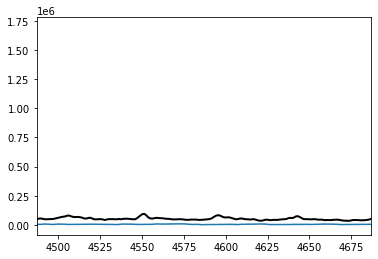

In [112]:
f, ax = plt.subplots()  
ax.step(new_spec_fluxcon.spectral_axis, new_spec_fluxcon.flux) 
plt.errorbar(sp.lambd-8, convolve(sp.flux*2.5e8, g2), yerr=sp.flux_err, c="k", linewidth=2)

#plt.ylim(0.5e4,6e4)
plt.xlim(wavmin,wavmax)

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/astropy-4.0-py3.6-linux-x86_64.egg/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/astropy-4.0-py3.6-linux-x86_64.egg/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/astropy-4.0-py3.6-linux-x86_64.egg/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/astropy-4.0-py3.6-linux-x86_64.egg/astropy/units/quantity.py:481: RuntimeWarning: invalid value encount

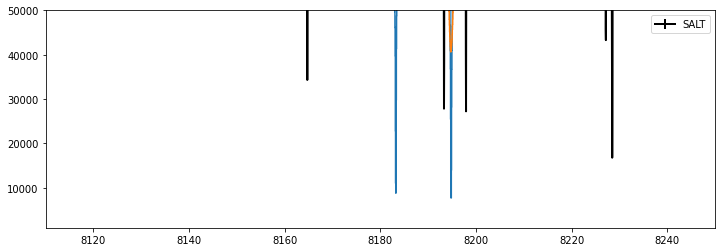

In [195]:
f, ax = plt.subplots(figsize=(12,4))  

# Create kernel
g = Gaussian1DKernel(stddev=12)
g2 = Gaussian1DKernel(stddev=1)

plt.errorbar(sp.lambd, convolve(sp.flux*1.5e8, g2), 
             yerr=sp.flux_err, c="k", linewidth=2, label="SALT")
#plt.plot(settl.lambd, settl.flux, c="k", linewidth=0.5)
new_disp_grid = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values * u.AA

for vsini, broad_spectrum in zip(vsinis, specs):
    # Convolve data
    flux = broad_spectrum* u.Unit('erg cm-2 s-1 AA-1') #settl2.flux.values 
    input_spec = Spectrum1D(spectral_axis=lamb, flux=flux) 
    new_spec_fluxcon = fluxcon(input_spec, new_disp_grid) 
    ax.step(new_spec_fluxcon.spectral_axis, new_spec_fluxcon.flux) 

    
plt.xlim(wavmin+10,wavmax-10)
plt.axvline(6562.78)
plt.ylim(.1e4,5e4)
plt.legend();